In [10]:
!pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 325.1 kB/s eta 0:00:02
   -- ------------------------------------ 41.0/626.3 kB 326.8 kB/s eta 0:00:02
   ------- ------------------------------ 122.9/626.3 kB 798.9 kB/s eta 0:00:01
   --------- ---------------------------- 153.6/626.3 kB 913.1 kB/s eta 0:00:01
   ----------------- ---------------------- 276.5/626.3 kB 1.1 MB/s eta 0:00:01
   -------------------- ------------------- 317.4/626.3 kB 1.2 MB/s eta 0:00:01
   -------------------------- ------------- 419.8/626.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------- ----------- 450.6/626.3 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- - 604.2/626.3 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 1.5 MB/s eta 0:00:00


In [13]:
!pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 640.0 kB/s eta 0:00:01
   ------------ --------------------------- 92.2/300.2 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------  297.0/300.2 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.1 MB/s eta 0:00:00


In [15]:
!pip install cufflinks

     ---------------------------------------- 0.0/81.7 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/81.7 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/81.7 kB ? eta -:--:--
     ------------------- ------------------ 41.0/81.7 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 81.7/81.7 kB 572.0 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=68724 sha256=c9086fddd126ec55d2d31e8d47ceb0d640393790158768085a81d549ce077c44
  Stored in directory: c:\users\satya\appdata\local\pip\cache\wheels\c3\bf\8f\afa0730b29e347e8c1071049f89748c1262e7a14a838820ae6
Successfully built cufflinks


# Step 1: Importing all the necessary libraries

In [21]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
warnings.warn("This will not show")

pd.set_option("display.max_columns", None)

# Step 2: Let's Import dataset

In [34]:
df = pd.read_csv("C:\\Users\\satya\\Downloads\\amazon_review.csv")

# Let's read our data.  There are total 4915 rows × 12 columns

In [35]:
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4910,A2LBMKXRM5H2W9,B007WTAJTO,"ZM ""J""","[0, 0]",I bought this Sandisk 16GB Class 10 to use wit...,1.0,Do not waste your money.,1374537600,2013-07-23,503,0,0
4911,ALGDLRUI1ZPCS,B007WTAJTO,Zo,"[0, 0]",Used this for extending the capabilities of my...,5.0,Great item!,1377129600,2013-08-22,473,0,0
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5.0,Fast and reliable memory card,1396224000,2014-03-31,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.0,Great little card,1379289600,2013-09-16,448,0,0


# Step 3: Any Missing values? Let's do EDA

## Let's create a function to check missing values

In [40]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.sum() == 0:
        print("No missing values found")
    else:
        print("Found Missing Values")
        missing_values = missing_values[missing_values > 0]
        missing_values = missing_values.sort_values()
    return missing_values

check_missing_values(df)

Found Missing Values


reviewerName    1
reviewText      1
dtype: int64

## As there is 1 missing value in each of these 2 categorical variables "reviewerName & reviewText", I decided to drop them as it causes no impact on the data because it is only 1 row

## Lets create a function to drop that 1 missing value in each of these 2 columns

In [53]:
def drop_missing_values(df,axis,how,subset,inplace):
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        if inplace:
            df.dropna(axis=axis, how=how, subset=subset, inplace=inplace)
        else:
            return df.dropna(axis=axis, how=how, subset=subset)
    else:
        return df
drop_missing_values(df=df,axis=0,how='any',subset=['reviewerName','reviewText'],inplace=True)

## checking null or missing values with info() method without creating function

### Let's check the missing values by calling the 'check_missing_values' function again

In [55]:
check_missing_values(df)

No missing values found


reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

### Now as our data set is clean,I would like to visualise the 'overall' column in our data which represents ratings from 1 to 5

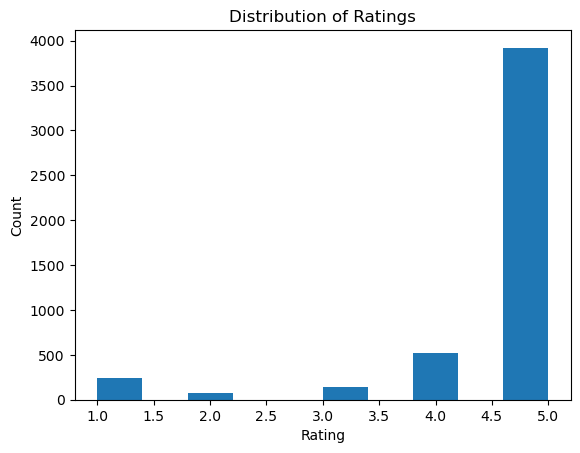

In [69]:
# Plotting the 'overall' column as a bar plot
overall_ratings = df['overall'].sort_index()
# print(overall_ratings)

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')

plt.hist(overall_ratings)
plt.show() 

### Now I would like to get the length of the column 'reviewText' and Visualise it

In [71]:
# Let's get the length of the teviewText
reviewText_length = df['reviewText'].apply(len)